# Assignment 2: Dynamic Programming for Reinforcement Learning

### Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tools

<Figure size 640x480 with 0 Axes>

In [3]:
num_spaces = 3
num_prices = 3
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1, num_prices)) / num_prices

In [4]:
V

array([0., 0., 0., 0.])

In [5]:
state = 0
V[state]

0.0

In [6]:
for s, v in enumerate(V):
    print(f'State {s} has value {v}')

State 0 has value 0.0
State 1 has value 0.0
State 2 has value 0.0
State 3 has value 0.0


In [7]:
pi

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [8]:
state = 0
pi[state]

array([0.33333333, 0.33333333, 0.33333333])

In [9]:
state = 0
value = 10
V[state] = value
V

array([10.,  0.,  0.,  0.])

In [10]:
state = 0
action = 1
pi[state, action]

0.3333333333333333

In [11]:
pi[state] = np.array([0.75, 0.21, 0.04])
pi

array([[0.75      , 0.21      , 0.04      ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [10]:
for s, pi_s in enumerate(pi):
    print(f''.join(f'pi(A={a}|S={s}) = {p.round(2)}' + 4 * ' ' for a, p in enumerate(pi_s)))

pi(A=0|S=0) = 0.33    pi(A=1|S=0) = 0.33    pi(A=2|S=0) = 0.33    
pi(A=0|S=1) = 0.33    pi(A=1|S=1) = 0.33    pi(A=2|S=1) = 0.33    
pi(A=0|S=2) = 0.33    pi(A=1|S=2) = 0.33    pi(A=2|S=2) = 0.33    
pi(A=0|S=3) = 0.33    pi(A=1|S=3) = 0.33    pi(A=2|S=3) = 0.33    


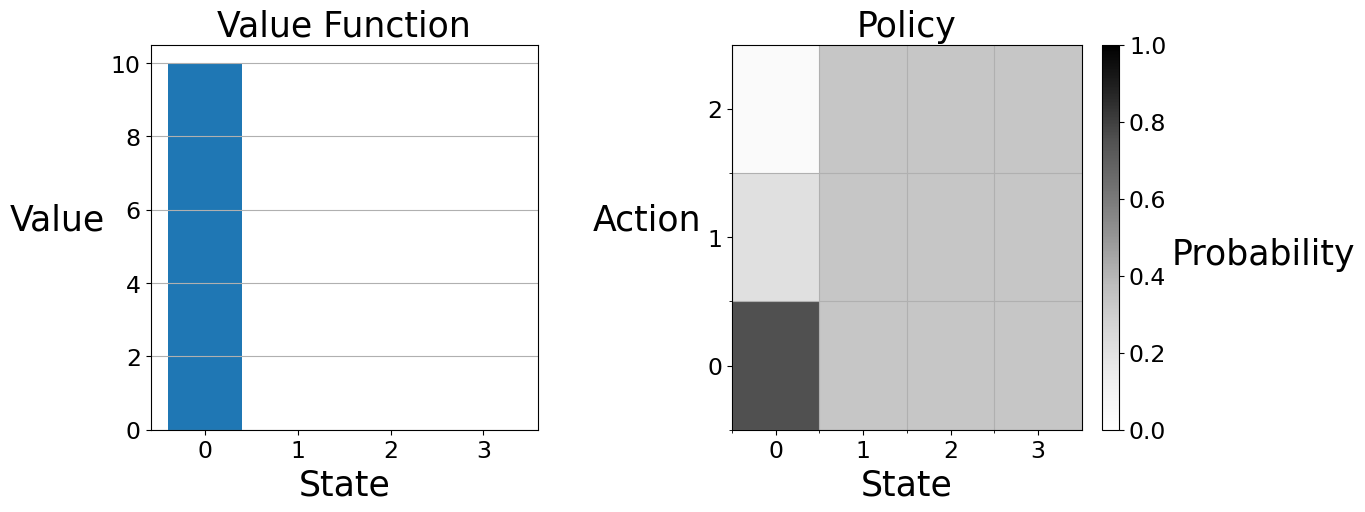

In [12]:
tools.plot(V, pi)

In [13]:
env.S

[0, 1, 2, 3]

In [14]:
env.A

[0, 1, 2]

In [15]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

array([[1.        , 0.12390437],
       [2.        , 0.15133714],
       [3.        , 0.1848436 ],
       [2.        , 0.53991488]])

In [15]:
for s_, (r, p) in enumerate(transitions):
    print(f'p(S\'={s_}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=1.0 | S=3, A=1) = 0.12
p(S'=1, R=2.0 | S=3, A=1) = 0.15
p(S'=2, R=3.0 | S=3, A=1) = 0.18
p(S'=3, R=2.0 | S=3, A=1) = 0.54


## Section 1: Policy Evaluation

In [18]:
def evaluate_policy(env, V, pi, gamma, theta):
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

In [21]:
def bellman_update(env, V, pi, s, gamma):
    v = 0
    for a in env.A:
        for s_, (r, p) in enumerate(env.transitions(s, a)):
            v += pi[s, a] * p * (r + gamma * V[s_])
    V[s] = v

In [22]:
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1
gamma = 0.9
theta = 0.1
V = evaluate_policy(env, V, city_policy, gamma, theta)

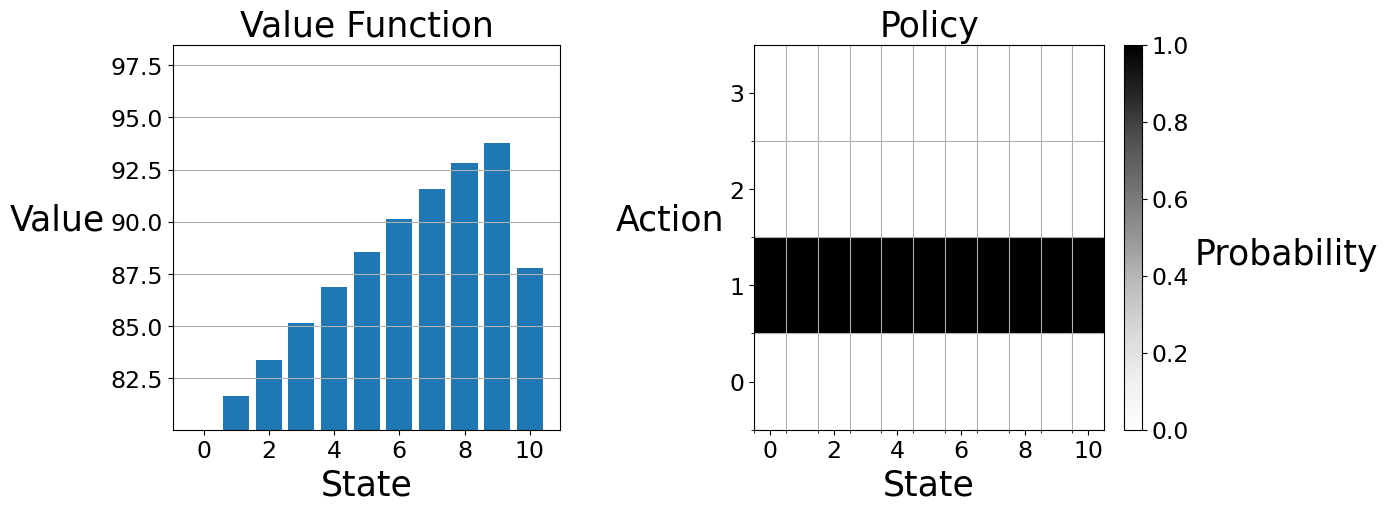

In [23]:
tools.plot(V, city_policy)

## Section 2: Policy Iteration

In [24]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old_action = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old_action):
            policy_stable = False
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    return V, pi

In [32]:
def q_greedify_policy(env, V, pi, s, gamma):
    max_v = float('-inf')
    max_a = 0
    for a in env.A:
        transitions = env.transitions(s, a)
        v = 0
        for s_ in env.S:
            v += transitions[s_][1] * (transitions[s_][0] + gamma * V[s_])
        if max_v < v:
            max_v = v
            max_a = a
    pi[s] = np.zeros_like(pi[s])
    pi[s][max_a] = 1

In [33]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

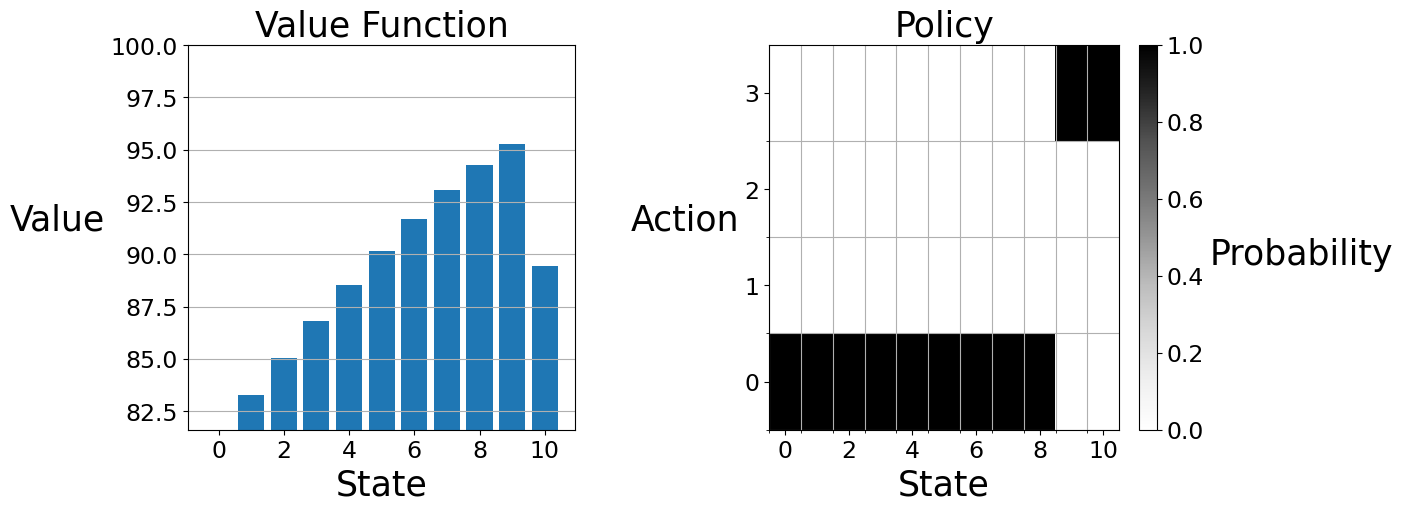

In [34]:
tools.plot(V, pi)

## Section 3: Value Iteration

In [36]:
def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [37]:
def bellman_optimality_update(env, V, s, gamma):
    max_v = float('-inf')
    for a in env.A:
        v = 0
        transitions = env.transitions(s, a)
        for s_ in env.S:
            v += transitions[s_][1] * ( transitions[s_][0] + gamma * V[s_] )
        if max_v < v:
            max_v = v
    V[s] = max_v

In [38]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

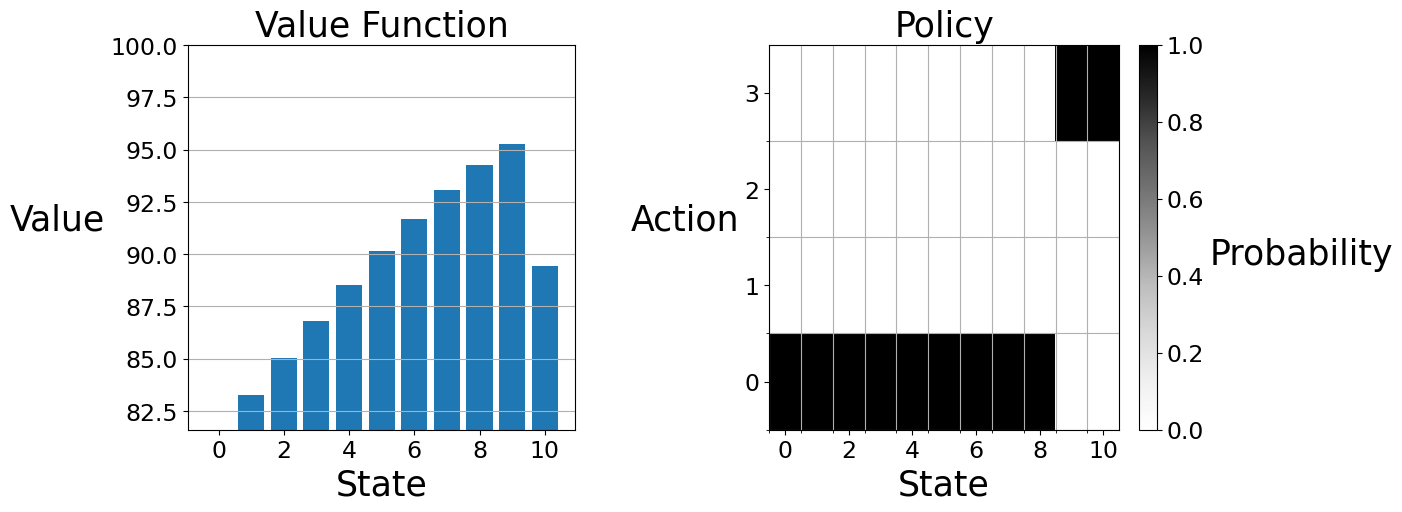

In [39]:
tools.plot(V, pi)

In [40]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

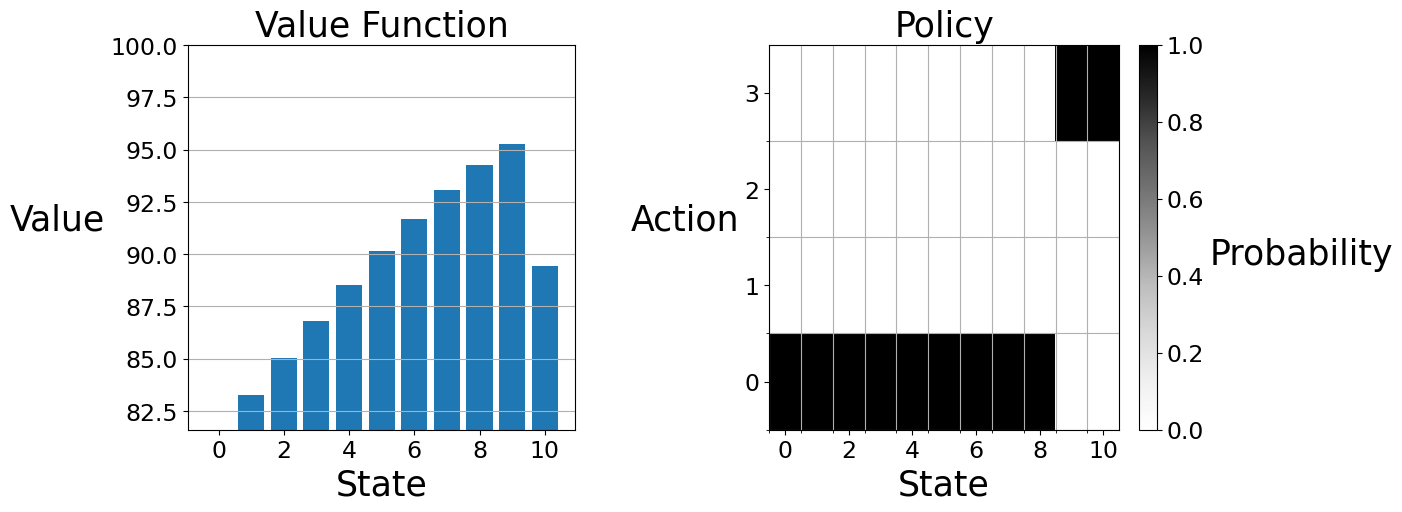

In [41]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
tools.plot(V, pi)

## Section 4: Asynchronous Methods

In [42]:
def real_time_dynamic_programming(env, gamma, horizon):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    s = env.random_state()
    for t in range(horizon):
        real_time_dynamic_programming_helper(env, V, pi, s, gamma)
        a = np.random.choice(env.A, p=pi[s])
        s = env.step(s, a)
    return V, pi

In [44]:
def real_time_dynamic_programming_helper(env, V, pi, s, gamma):
    q_greedify_policy(env, V, pi, s, gamma)
    
    v = 0
    ai = np.argmax(pi[s])
    transitions = env.transitions(s, ai)
    for s_ in env.S:
        new_v += transitions[s_][1] * (transitions[s_][0] + gamma * V[s_])
    V[s] = v

In [45]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
horizon = 500
np.random.seed(101)
V, pi = real_time_dynamic_programming(env, gamma, horizon)

UnboundLocalError: local variable 'new_v' referenced before assignment